# Survey and twiss around IPs

###  Beam Position in lab frame


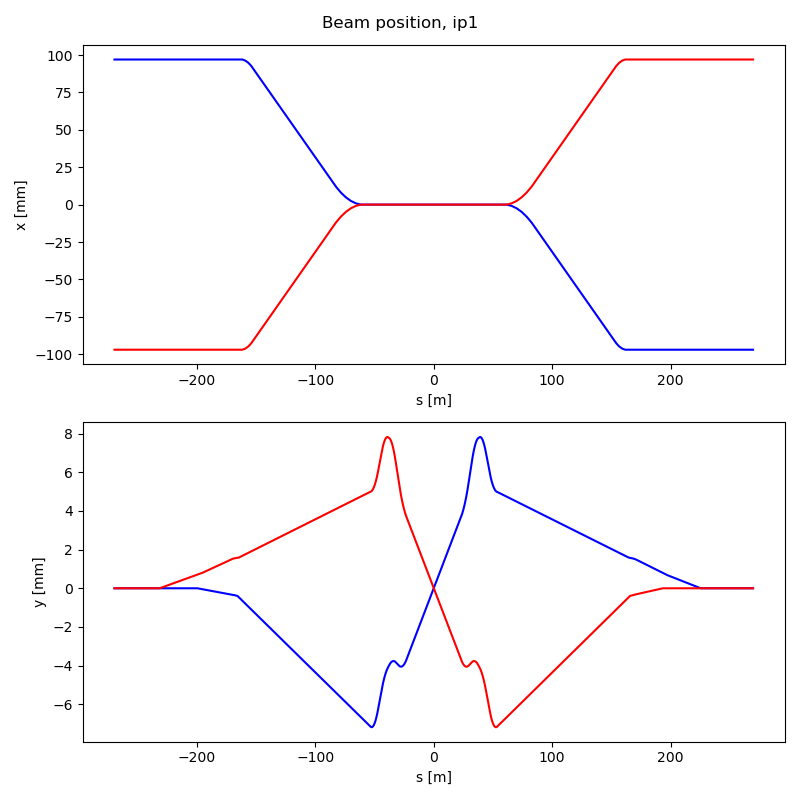

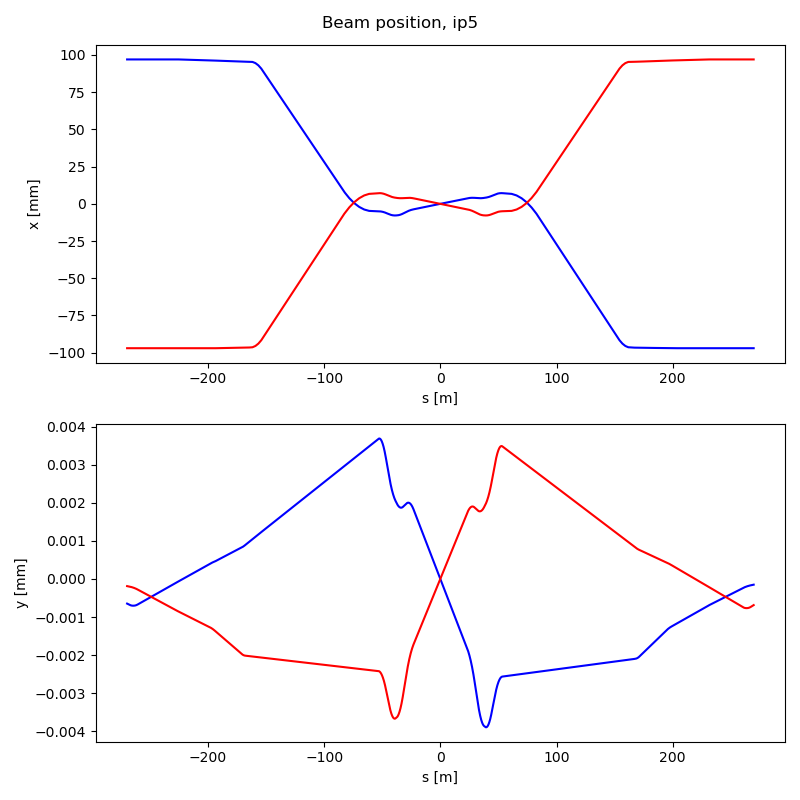

In [13]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import Backend.Crossing as cross


# Importing twiss and survey
twiss_b1  = pd.read_pickle('LHC_sequence/lhcb1_twiss.pkl')
survey_b1 = pd.read_pickle('LHC_sequence/lhcb1_survey.pkl')

twiss_b2  = pd.read_pickle('LHC_sequence/lhcb2_twiss.pkl')
survey_b2 = pd.read_pickle('LHC_sequence/lhcb2_survey.pkl')


chosenIPs = ['ip1','ip5']
for _IP in chosenIPs:

    # ROI around IP
    ROI_twiss_b1,ROI_survey_b1 = cross.extract_IP_ROI(_IP,'b1',twiss_b1,survey_b1)
    ROI_twiss_b2,ROI_survey_b2 = cross.extract_IP_ROI(_IP,'b2',twiss_b2,survey_b2)

    # Plotting
    
    fig, axes = plt.subplots(2, 1,figsize=(8,8))
    fig.suptitle(f'Beam position, {_IP}')
    for plane,ax in zip(['x','y'],axes.flatten()):
        
        center = ROI_twiss_b1.loc[_IP,f'{plane}_lab']
        ax.plot(ROI_twiss_b1['s_lab'],(ROI_twiss_b1[f'{plane}_lab']-center)/1e-3,'b-')
        ax.plot(ROI_twiss_b2['s_lab'],(ROI_twiss_b2[f'{plane}_lab']-center)/1e-3,'r-')
    
        ax.set(xlabel='s [m]', ylabel=f'{plane} [mm]')
    plt.tight_layout()



###  Survey around IP

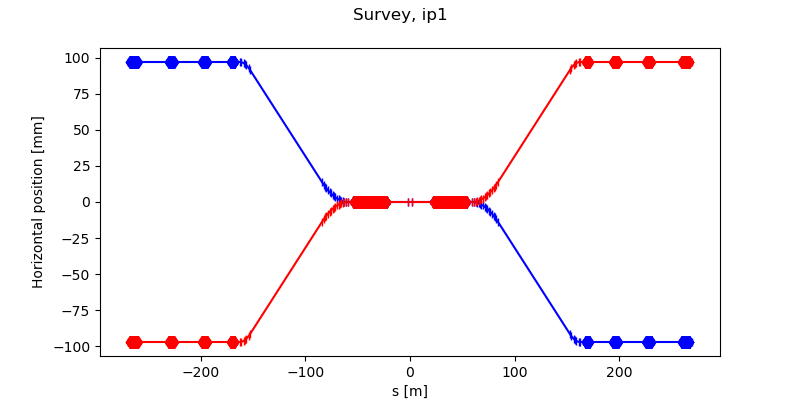

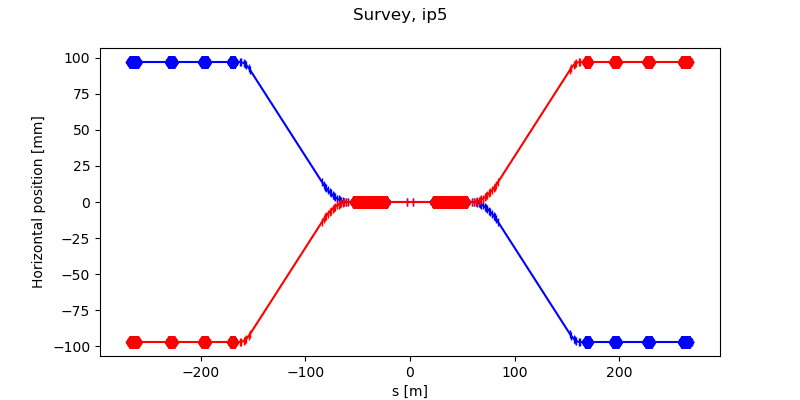

In [20]:
def magnetType(text):
    if 'mb' in text.lower():
        return 'mb'
    elif 'mq' in text.lower():
        return 'mq'
    else:
        return 'other'
    
    
chosenIPs = ['ip1','ip5']
for _IP in chosenIPs:

    # ROI around IP
    ROI_twiss_b1,ROI_survey_b1 = cross.extract_IP_ROI(_IP,'b1',twiss_b1,survey_b1)
    ROI_twiss_b2,ROI_survey_b2 = cross.extract_IP_ROI(_IP,'b2',twiss_b2,survey_b2)

    # Classifying magnet types:
    ROI_survey_b1.insert(1,'type',ROI_survey_b1['name'].apply(magnetType))
    ROI_survey_b2.insert(1,'type',ROI_survey_b2['name'].apply(magnetType))
    
    # Plotting
    fig = plt.figure(figsize=(8,4))
    fig.suptitle(f'Survey, {_IP}')
    
    center = ROI_survey_b1.loc[_IP,'z_rot']
    plt.plot(ROI_survey_b1['s_rot'],(ROI_survey_b1['z_rot']-center)/1e-3,'b-')
    plt.plot(ROI_survey_b2['s_rot'],(ROI_survey_b2['z_rot']-center)/1e-3,'r-')
    
    for magnet,marker in zip(['mb','mq'],['|','d']):
        magnet_b1 = ROI_survey_b1.groupby('type').get_group(magnet)
        magnet_b2 = ROI_survey_b2.groupby('type').get_group(magnet)
    
        plt.plot(magnet_b1['s_rot'],(magnet_b1['z_rot']-center)/1e-3,f'b{marker}')
        plt.plot(magnet_b2['s_rot'],(magnet_b2['z_rot']-center)/1e-3,f'r{marker}')
    
    plt.xlabel('s [m]')
    plt.ylabel('Horizontal position [mm]')
    
    

## Beam-Beam distance


In [19]:


chosenIPs = ['ip1','ip5']
for _IP in chosenIPs:

    # ROI around IP
    ROI_twiss_b1,ROI_survey_b1 = cross.extract_IP_ROI(_IP,'b1',twiss_b1,survey_b1)
    ROI_twiss_b2,ROI_survey_b2 = cross.extract_IP_ROI(_IP,'b2',twiss_b2,survey_b2)



for _IP in ['ip1','ip5']:
    
    # Proper orientation
    if _IP == 'ip1':
        rot = -1
    else:
        rot = 1

    # ROI from dipoles
    ROI_ip_b1 = twiss_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    ROI_ip_b2 = twiss_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

    survey_ip_b1 = survey_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    survey_ip_b2 = survey_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

      
    # lab frame coordinates
    ROI_ip_b1.insert(1,'x_lab',ROI_ip_b1['x'] + rot*survey_ip_b1['z'])
    ROI_ip_b2.insert(1,'x_lab',ROI_ip_b2['x'] + rot*survey_ip_b2['z'])
    
    ROI_ip_b1.insert(1,'y_lab',ROI_ip_b1['y'] + survey_ip_b1['y'])
    ROI_ip_b2.insert(1,'y_lab',ROI_ip_b2['y'] + survey_ip_b2['y'])
    
    center_s = ROI_ip_b1.loc[_IP,'s']
    
    
    
    # interpolating to plot
    sVec = np.linspace(-200,200,2000)
    
    b1_x = np.interp(sVec, ROI_ip_b1['s']-center_s, ROI_ip_b1['x_lab'])
    b1_y = np.interp(sVec, ROI_ip_b1['s']-center_s, ROI_ip_b1['y_lab'])
    
    b2_x = np.interp(sVec, ROI_ip_b2['s']-center_s, ROI_ip_b2['x_lab'])
    b2_y = np.interp(sVec, ROI_ip_b2['s']-center_s, ROI_ip_b2['y_lab'])
    
                                               
    d_bb = np.sqrt((b1_x-b2_x)**2 + (b1_y-b2_y)**2)
    

    plt.figure(_IP + 'separation')
    plt.plot(sVec,d_bb/1e-3,'k')
    plt.xlim([-60,60])
    plt.ylim([-5,20])
    plt.axhline(0)

    plt.xlabel('s [m]')
    plt.ylabel('x [mm]')



FileNotFoundError: [Errno 2] No such file or directory: 'lhcb1_twiss.pkl'

# In terms of beam sigma

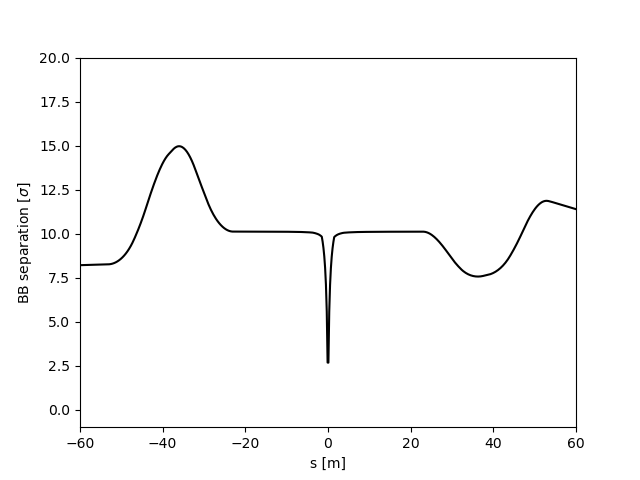

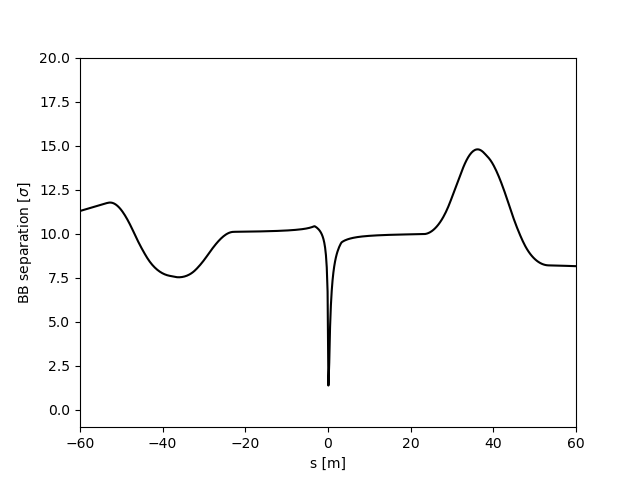

In [6]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import Backend.Constants as cst
emitt = 2.5e-6/(1+ 6800e9/cst.m_p_eV)

twiss_b1  = pd.read_pickle('LHC_sequence/lhcb1_twiss.pkl')
survey_b1 = pd.read_pickle('LHC_sequence/lhcb1_survey.pkl')

twiss_b2  = pd.read_pickle('LHC_sequence/lhcb2_twiss.pkl')
survey_b2 = pd.read_pickle('LHC_sequence/lhcb2_survey.pkl')

def magnetType(text):
    if 'mb' in text.lower():
        return 'mb'
    elif 'mq' in text.lower():
        return 'mq'
    else:
        return 'other'
    

for _IP in ['ip1','ip5']:
    
    # Proper orientation
    if _IP == 'ip1':
        rot = -1
    else:
        rot = 1

    # ROI from dipoles
    ROI_ip_b1 = twiss_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    ROI_ip_b2 = twiss_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

    survey_ip_b1 = survey_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    survey_ip_b2 = survey_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

      
    # lab frame coordinates
    ROI_ip_b1.insert(1,'x_lab',ROI_ip_b1['x'] + rot*survey_ip_b1['z'])
    ROI_ip_b2.insert(1,'x_lab',ROI_ip_b2['x'] + rot*survey_ip_b2['z'])
    
    ROI_ip_b1.insert(1,'y_lab',ROI_ip_b1['y'] + survey_ip_b1['y'])
    ROI_ip_b2.insert(1,'y_lab',ROI_ip_b2['y'] + survey_ip_b2['y'])
    
    center_s = ROI_ip_b1.loc[_IP,'s']
    
    
    
    # interpolating to plot
    sVec = np.linspace(-200,200,2000)
    
    b1_x   = np.interp(sVec, ROI_ip_b1['s']-center_s, ROI_ip_b1['x_lab'])
    sig1_x = np.interp(sVec, ROI_ip_b1['s']-center_s, np.sqrt(ROI_ip_b1['betx']*emitt))
    b1_y   = np.interp(sVec, ROI_ip_b1['s']-center_s, ROI_ip_b1['y_lab'])
    sig1_y = np.interp(sVec, ROI_ip_b1['s']-center_s, np.sqrt(ROI_ip_b1['bety']*emitt))
    
    b2_x   = np.interp(sVec, ROI_ip_b2['s']-center_s, ROI_ip_b2['x_lab'])
    sig2_x = np.interp(sVec, ROI_ip_b2['s']-center_s, np.sqrt(ROI_ip_b2['betx']*emitt))
    b2_y   = np.interp(sVec, ROI_ip_b2['s']-center_s, ROI_ip_b2['y_lab'])
    sig2_y = np.interp(sVec, ROI_ip_b2['s']-center_s, np.sqrt(ROI_ip_b2['bety']*emitt))
                                               
    d_bb = np.sqrt((b1_x-b2_x)**2/sig1_x**2 + (b1_y-b2_y)**2/sig1_y**2)
    

    plt.figure(_IP + 'separation')
    plt.plot(sVec,d_bb,'k')
    plt.xlim([-60,60])
    plt.ylim([-1,20])
    #plt.axhline(0)

    plt.xlabel('s [m]')
    plt.ylabel(r'BB separation [$\sigma$]')



# Footprint

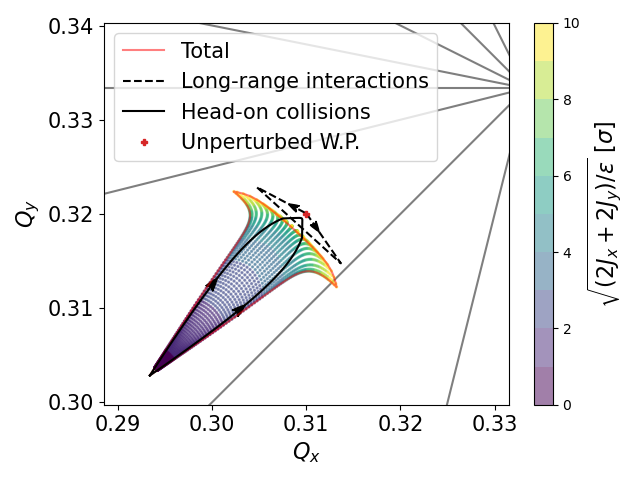

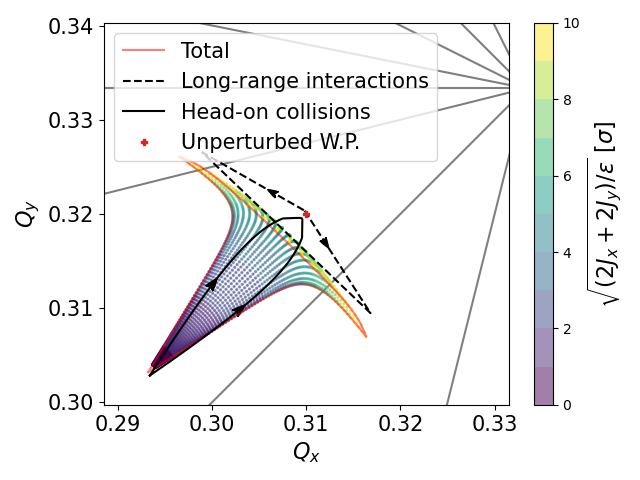

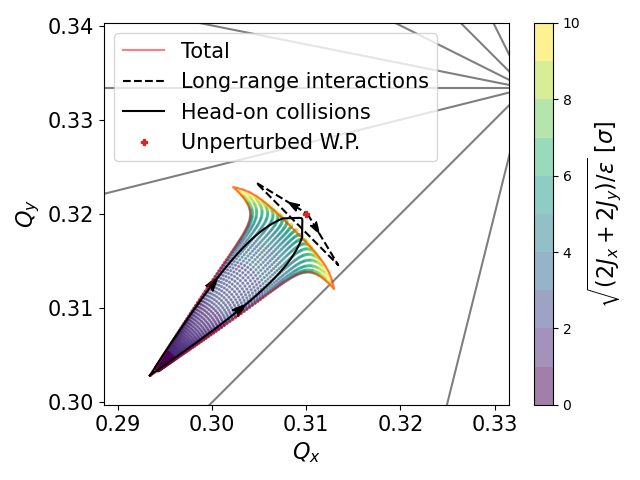

In [7]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sciSpec
import scipy.integrate as integrate
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import FancyArrowPatch


import Backend.Constants as cst
import Backend.Footprint as fp
import Backend.WCTools as WCTools
import Backend.BeamPhysics as BP

twiss_b1  = pd.read_pickle('LHC_sequence/lhcb1_twiss.pkl')
survey_b1 = pd.read_pickle('LHC_sequence/lhcb1_survey.pkl')

twiss_b2  = pd.read_pickle('LHC_sequence/lhcb2_twiss.pkl')
survey_b2 = pd.read_pickle('LHC_sequence/lhcb2_survey.pkl')


def bet_s(s,plane,_IP):
    ROI_ip_b1 = twiss_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    center_s = ROI_ip_b1.loc[_IP,'s']

    return np.interp(s, ROI_ip_b1['s']-center_s,ROI_ip_b1[f'bet{plane}'])

def d_BB(s,_IP):
    # Proper orientation
    if _IP == 'ip1':
        rot = -1
    else:
        rot = 1

    # ROI from dipoles
    ROI_ip_b1 = twiss_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    ROI_ip_b2 = twiss_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

    survey_ip_b1 = survey_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    survey_ip_b2 = survey_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

      
    # lab frame coordinates
    ROI_ip_b1.insert(1,'x_lab',ROI_ip_b1['x'] + rot*survey_ip_b1['z'])
    ROI_ip_b2.insert(1,'x_lab',ROI_ip_b2['x'] + rot*survey_ip_b2['z'])
    
    ROI_ip_b1.insert(1,'y_lab',ROI_ip_b1['y'] + survey_ip_b1['y'])
    ROI_ip_b2.insert(1,'y_lab',ROI_ip_b2['y'] + survey_ip_b2['y'])
    
    center_s = ROI_ip_b1.loc[_IP,'s']
        
    b1_x   = np.interp(s, ROI_ip_b1['s']-center_s, ROI_ip_b1['x_lab'])
    b1_y   = np.interp(s, ROI_ip_b1['s']-center_s, ROI_ip_b1['y_lab'])
    
    b2_x   = np.interp(s, ROI_ip_b2['s']-center_s, ROI_ip_b2['x_lab'])
    b2_y   = np.interp(s, ROI_ip_b2['s']-center_s, ROI_ip_b2['y_lab'])
                                               
    return (b2_x-b1_x),(b2_y-b1_y)


def drawArrow(x,y,scale=2,rotate=0,color='C0',alpha=1,label = None):
    ax = plt.gca()
    ax.plot(x[:-2], y[:-2], color=color,alpha=alpha,label=label)
    posA, posB = zip(x[-2:], y[-2:])
    edge_width = 2.*scale
    anglestyle = "arc3,rad={}".format(np.radians(rotate))
    #arrowstyle was 3*edge_width,3*edge_width,edge_width before.
    arrowstyle = "fancy,head_length={},head_width={},tail_width={}".format(3*edge_width, 2*edge_width, 2*edge_width)

    arrow = FancyArrowPatch(posA=posA, posB=posB, arrowstyle=arrowstyle, connectionstyle=anglestyle,color=color)
    ax.add_artist(arrow)

def get_LongRange(coords,knl,twiss):
    betx,bety = twiss['betx'],twiss['bety']
    
    # Quadrupole contribution
    DQx = 1/(4*np.pi)*knl[1]*betx
    DQy = -1/(4*np.pi)*knl[1]*bety
    
    
    # Quadrupole contribution
    DQx += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(betx**2 * coords['J_x'] - 2*betx*bety*coords['J_y'])
    DQy += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(bety**2 * coords['J_y'] - 2*bety*betx*coords['J_x'])
    
    return DQx,DQy

    
def get_HeadOn(coords,N_p,E,emitt,twiss):
    betx,bety = twiss['betx'],twiss['bety']   
    Jx,Jy = np.array(coords['J_x']),np.array(coords['J_y'])
    
    # Beam-Beam parameter
    gamma = 1+E/cst.m_p_eV
    rp = cst.elec**2/(4*np.pi*cst.eps0*cst.m_p*cst.c**2)
    
    sigx = np.sqrt(betx*emitt)
    sigy = np.sqrt(bety*emitt)
    BBx = -N_p*rp*betx/(2*np.pi*gamma*sigx*(sigx+sigy))
    BBy = -N_p*rp*bety/(2*np.pi*gamma*sigy*(sigx+sigy))
    
    
    # Tune shifts, z is integration varable
    
    DQx = []
    DQy = []
    for Jx,Jy in zip(np.array(coords['J_x']),np.array(coords['J_y'])):
        _DQx,_ = integrate.quad(lambda z: BBx/(1+z**2)*np.exp(-(Jx+Jy)/(2*emitt*(1+z)))*sciSpec.iv(0,Jy/(2*emitt*(1+z)))*(sciSpec.iv(0,Jx/(2*emitt*(1+z)))-sciSpec.iv(1,Jx/(2*emitt*(1+z)))), 0, np.inf)
        _DQy,_ = integrate.quad(lambda z: BBy/(1+z**2)*np.exp(-(Jx+Jy)/(2*emitt*(1+z)))*sciSpec.iv(0,Jx/(2*emitt*(1+z)))*(sciSpec.iv(0,Jy/(2*emitt*(1+z)))-sciSpec.iv(1,Jy/(2*emitt*(1+z)))), 0, np.inf)
        DQx.append(_DQx)
        DQy.append(_DQy)
        
    return np.array(DQx),np.array(DQy)





# Starting Tunes
#=========================================================
Qx_0,Qy_0 = 0.31,0.32
N_p = 1.1e11
E   = 6.8e12
p0  = np.sqrt(E**2-cst.m_p_eV**2)/cst.c

# Beta functions
#_twiss_ip1 = {'betx':0.330,'bety':0.33}
#_twiss_ip5 = {'betx':0.335,'bety':0.347}
_twiss_ip1 = {'betx':twiss_b1.loc['ip1','betx'],'bety':twiss_b1.loc['ip1','bety']}
_twiss_ip5 = {'betx':twiss_b1.loc['ip5','betx'],'bety':twiss_b1.loc['ip5','bety']}


#=========================================================

# Generating Coord grid
#=========================================================
#coordinates = fp.generate_coordGrid([0.05,10],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r_n','theta_n'],nPoints=500)
coordinates = fp.generate_coordGrid(np.logspace(np.log10(0.5),np.log10(10),100),
                                    np.linspace(0.01*np.pi/2,0.99*np.pi/2,20),labels = ['r_n','theta_n'])

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

emitt = 2.5e-6/(1+ 6800e9/cst.m_p_eV)
coordinates.insert(0,'J_x',(coordinates['x_n']**2)*emitt/2)
coordinates.insert(1,'J_y',(coordinates['y_n']**2)*emitt/2)

coordinates.sort_values(by=['r_n'],inplace=True)
#=========================================================


# Generating Contours
#=========================================================

p_by_seg = 1000

cr     = np.array(list(np.linspace(0,10,p_by_seg)) + list(10*np.ones(p_by_seg))             + list(np.flip(np.linspace(0,10,p_by_seg))))
ctheta = np.array(list(np.zeros(p_by_seg))         + list(np.linspace(0,np.pi/2,p_by_seg)) + list(np.pi/2*np.ones(p_by_seg)))
ctour = pd.DataFrame({'r_n':cr,'theta_n':ctheta})

ctour.insert(0,'x_n',ctour['r_n']*np.cos(ctour['theta_n']))
ctour.insert(1,'y_n',ctour['r_n']*np.sin(ctour['theta_n']))


emitt = 2.5e-6/(1+ 6800e9/cst.m_p_eV)
ctour.insert(0,'J_x',(ctour['x_n']**2)*emitt/2)
ctour.insert(1,'J_y',(ctour['y_n']**2)*emitt/2)

#=========================================================


###################
# Head-on
###################
DQx_HO,DQy_HO = 0,0
Cx_HO,Cy_HO = 0,0
for ip in [_twiss_ip1,_twiss_ip5]:
    _Dx,_Dy = get_HeadOn(coordinates,N_p=N_p,E=E,emitt=emitt,twiss=ip)
    DQx_HO += _Dx
    DQy_HO += _Dy

    # Contours
    _Dx,_Dy = get_HeadOn(ctour,N_p=N_p,E=E,emitt=emitt,twiss=ip)
    Cx_HO += _Dx
    Cy_HO += _Dy


###################
# Long-range
    

N_LR   = 18*2
for PACMAN_pos,name in zip([0,N_LR//2,N_LR],['First','Middle','Last']):
    N_L = N_LR-PACMAN_pos
    N_R = N_LR-N_L

    s_BBLR = np.arange(0,150,7.5/2)[1:]
    s_BBLR = np.concatenate((-np.flip(s_BBLR),s_BBLR))
    
    
    # IP 1
    #========================
    
    _IP = 'ip1'
    
    DQx_ip1,DQy_ip1 = 0,0
    Cx_ip1,Cy_ip1   = 0,0
    
    for s_int in s_BBLR[len(s_BBLR)//2-N_L:len(s_BBLR)//2+N_R]:


        IL_eq = N_p*cst.elec*cst.c
        x,y = d_BB(s_int,_IP=_IP)
        
        _knl,_ = WCTools.getMultiCoeff(-IL_eq,1,[x,y],nmax=5)
        _knl   = _knl/p0
        
        _DQx, _DQy = get_LongRange(coordinates,knl = _knl,twiss= {'betx':bet_s(s_int,'x',_IP),'bety':bet_s(s_int,'y',_IP)})      
        DQx_ip1 += _DQx
        DQy_ip1 += _DQy
        
        _Cx,_Cy   = get_LongRange(ctour,knl = _knl,twiss= {'betx':bet_s(s_int,'x',_IP),'bety':bet_s(s_int,'y',_IP)})      
        Cx_ip1 += _Cx
        Cy_ip1 += _Cy
        
        
    # IP 5
    #========================
    
    _IP = 'ip5'
    
    DQx_ip5,DQy_ip5 = 0,0
    Cx_ip5,Cy_ip5   = 0,0
    for s_int in s_BBLR[len(s_BBLR)//2-N_L:len(s_BBLR)//2+N_R]:


        IL_eq = N_p*cst.elec*cst.c
        x,y = d_BB(s_int,_IP=_IP)
        
        _knl,_ = WCTools.getMultiCoeff(-IL_eq,1,[x,y],nmax=5)
        _knl   = _knl/p0
        
        _DQx, _DQy = get_LongRange(coordinates,knl = _knl,twiss= {'betx':bet_s(s_int,'x',_IP),'bety':bet_s(s_int,'y',_IP)})      
        DQx_ip5 += _DQx
        DQy_ip5 += _DQy
        
        _Cx,_Cy   = get_LongRange(ctour,knl = _knl,twiss= {'betx':bet_s(s_int,'x',_IP),'bety':bet_s(s_int,'y',_IP)})      
        Cx_ip5 += _Cx
        Cy_ip5 += _Cy
        
        
        
    # Plotting
    #==============
    color = 'viridis'
    window = 0.02


    plt.figure()
    BP.plotWorkingDiagram(order = 6,QxRange=np.array([0.25,0.35]),QyRange=np.array([0.25,0.35]),zorder=-1000)
    #plt.scatter(Qx_0 + DQx_HO+ DQx_ip1+ DQx_ip5,Qy_0 + DQy_HO + DQy_ip1 +DQy_ip5,s=2,c=coordinates['r_n'],zorder=1000)
    
    plt.plot(Qx_0+Cx_HO+Cx_ip1+Cx_ip5,Qy_0+Cy_HO+Cy_ip1+Cy_ip5,alpha=0.5,color='red',label='Total')
    
    plt.scatter(Qx_0 + DQx_HO+ DQx_ip1+ DQx_ip5,Qy_0 + DQy_HO + DQy_ip1 +DQy_ip5,s=2,
                c=coordinates['r_n'],alpha=0.5,norm = BoundaryNorm(boundaries=np.linspace(0,10,11), ncolors=256))

    
    plt.plot(Qx_0+Cx_ip1+Cx_ip5,Qy_0+Cy_ip1+Cy_ip5,'--',label='Long-range interactions',color='k')
    _x,_y = Qx_0+Cx_ip1+Cx_ip5,Qy_0+Cy_ip1+Cy_ip5
    start,stop = len(_x)//5,len(_x)//5+3
    drawArrow(_x[start:stop],_y[start:stop],scale=1.2,rotate=0,color='k',alpha=1,label = None)
    start,stop = 4*len(_x)//5,4*len(_x)//5+3
    drawArrow(_x[start:stop][::-1],_y[start:stop][::-1],scale=1.2,rotate=0,color='k',alpha=1,label = None)

    plt.plot(Qx_0+Cx_HO,Qy_0+Cy_HO,color='k',label='Head-on collisions')   
    _x,_y = Qx_0+Cx_HO,Qy_0+Cy_HO
    start,stop = len(_x)//12,len(_x)//12+3
    drawArrow(_x[start:stop],_y[start:stop],scale=1.5,rotate=0,color='k',alpha=1,label = None)
    start,stop = 11*len(_x)//12,11*len(_x)//12+3
    drawArrow(_x[start:stop][::-1],_y[start:stop][::-1],scale=1.5,rotate=0,color='k',alpha=1,label = None)

    plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')
    #h4, = plt.plot([Qx_0],[Qy_0],'o',markersize=3,color='C3')
    plt.axis('equal')

    plt.xlim([0.31-window,0.31+window])
    plt.ylim([0.32-window,0.32+window])
    cbar = plt.colorbar()
    #plt.clim(-2,1.2*np.max(coordinates['r_n']))
    plt.set_cmap(color)
    cbar.ax.set_ylim([0,np.max(coordinates['r_n'])])

    plt.legend(fontsize=15)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

    plt.xlabel(r'$Q_x$',fontsize=16)
    plt.ylabel(r'$Q_y$',fontsize=16)
    cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=16)

    plt.tight_layout()
    #plt.savefig('./Figures/footprint_analytic.pdf',format='pdf')
    #plt.savefig('./Figures/footprint_analytic.png',format='png',dpi=300)






0.33371639784616647

# Test PACMAN location

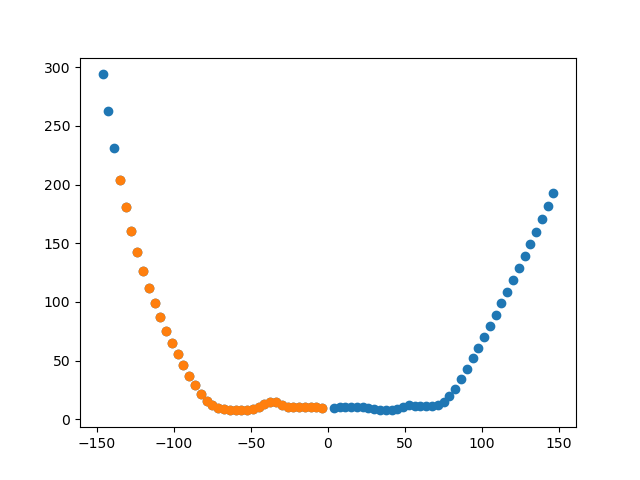

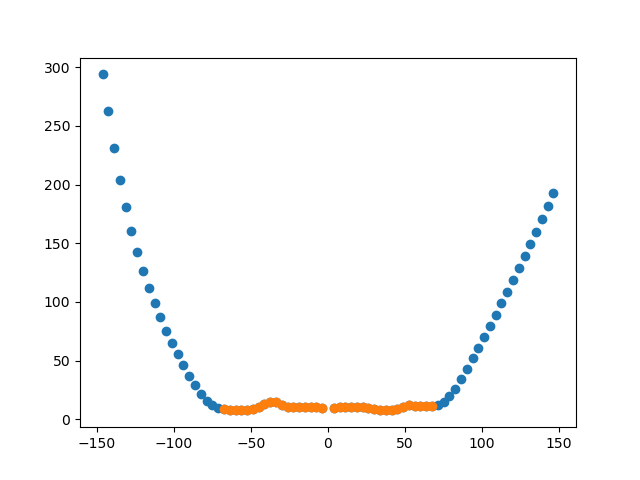

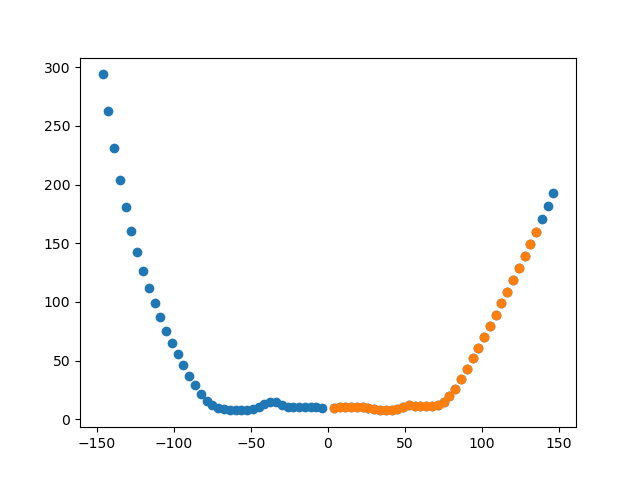

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sciSpec
import scipy.integrate as integrate
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import FancyArrowPatch


import Backend.Constants as cst
import Backend.Footprint as fp
import Backend.WCTools as WCTools
import Backend.BeamPhysics as BP

twiss_b1  = pd.read_pickle('lhcb1_twiss.pkl')
survey_b1 = pd.read_pickle('lhcb1_survey.pkl')

twiss_b2  = pd.read_pickle('lhcb2_twiss.pkl')
survey_b2 = pd.read_pickle('lhcb2_survey.pkl')


def bet_s(s,plane,_IP):
    ROI_ip_b1 = twiss_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    center_s = ROI_ip_b1.loc[_IP,'s']

    return np.interp(s, ROI_ip_b1['s']-center_s,ROI_ip_b1[f'bet{plane}'])

def d_BB(s,_IP):
    # Proper orientation
    if _IP == 'ip1':
        rot = -1
    else:
        rot = 1

    # ROI from dipoles
    ROI_ip_b1 = twiss_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    ROI_ip_b2 = twiss_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

    survey_ip_b1 = survey_b1.loc[f'mb.a8l{_IP[-1]}.b1_dex':f'mb.a8r{_IP[-1]}.b1_den']
    survey_ip_b2 = survey_b2.loc[f'mb.a8l{_IP[-1]}.b2_dex':f'mb.a8r{_IP[-1]}.b2_den']

      
    # lab frame coordinates
    ROI_ip_b1.insert(1,'x_lab',ROI_ip_b1['x'] + rot*survey_ip_b1['z'])
    ROI_ip_b2.insert(1,'x_lab',ROI_ip_b2['x'] + rot*survey_ip_b2['z'])
    
    ROI_ip_b1.insert(1,'y_lab',ROI_ip_b1['y'] + survey_ip_b1['y'])
    ROI_ip_b2.insert(1,'y_lab',ROI_ip_b2['y'] + survey_ip_b2['y'])
    
    center_s = ROI_ip_b1.loc[_IP,'s']
        
    b1_x   = np.interp(s, ROI_ip_b1['s']-center_s, ROI_ip_b1['x_lab'])
    b1_y   = np.interp(s, ROI_ip_b1['s']-center_s, ROI_ip_b1['y_lab'])
    
    b2_x   = np.interp(s, ROI_ip_b2['s']-center_s, ROI_ip_b2['x_lab'])
    b2_y   = np.interp(s, ROI_ip_b2['s']-center_s, ROI_ip_b2['y_lab'])
                                               
    return (b2_x-b1_x),(b2_y-b1_y)


N_LR   = 18*2
for PACMAN_pos,name in zip([0,N_LR//2,N_LR],['First','Middle','Last']):
    N_L = N_LR-PACMAN_pos
    N_R = N_LR-N_L

    s_BBLR = np.arange(0,150,7.5/2)[1:]
    s_BBLR = np.concatenate((-np.flip(s_BBLR),s_BBLR))
    
    d_x,d_y = d_BB(s_BBLR,_IP='ip1')
    sigma = np.sqrt(emitt*bet_s(s_BBLR,'y','ip1'))
    D = np.sqrt(d_x**2+d_y**2)/sigma
    
    #pacman
    s_PAC = s_BBLR[len(s_BBLR)//2-N_L:len(s_BBLR)//2+N_R]
    d_x,d_y = d_BB(s_PAC,_IP='ip1')
    sigma = np.sqrt(emitt*bet_s(s_PAC,'y','ip1'))
    D_PAC = np.sqrt(d_x**2+d_y**2)/sigma
    
    
    plt.figure(name)
    plt.plot(s_BBLR,D,'o',color='C0')
    plt.plot(s_PAC,D_PAC,'o',color='C1')



# Creating pickle files

In [119]:

for seq in ['lhcb1','lhcb2']:
    mad_track.input(f'use, sequence={seq};')
    mad_track.twiss()
    mad_track.survey()
    
    twiss = mad_track.table.twiss.dframe()
    survey = mad_track.table.survey.dframe()

    twiss.to_pickle(f"{seq}_twiss.pkl")
    survey.to_pickle(f"{seq}_survey.pkl")

In [113]:
%cd /home/pbelange/abp/Apps/lhcmask/python_examples/run3_collisions_wire
%run 000_pymask.py
%cd /home/pbelange/abp/footprint

Output()

/home/pbelange/abp/Apps/lhcmask/python_examples/run3_collisions_wire


bash: customization.bash: No such file or directory
GC Warning: Repeated allocation of very large block (appr. size 491520):
	May lead to memory leak and poor performance
GC Warning: Repeated allocation of very large block (appr. size 491520):
	May lead to memory leak and poor performance
GC Warning: Repeated allocation of very large block (appr. size 491520):
	May lead to memory leak and poor performance


IP beta test against knobs passed!
IP separation test against knobs passed!
IP beta test against knobs passed!
IP separation test against knobs passed!
Luminosities before leveling (crab cavities are not considered):
L in ip1 is 2.5834412775786533e+34 Hz/cm^2
L in ip2 is 1.5197302224975641e-93 Hz/cm^2
L in ip5 is 2.6254177545614155e+34 Hz/cm^2
L in ip8 is 0.0 Hz/cm^2
Start pythonic leveling:
L in ip1 is 2.583038716997818e+34 Hz/cm^2
L in ip2 is 2.0827129610563726e+30 Hz/cm^2
L in ip5 is 2.6252120368603296e+34 Hz/cm^2
L in ip8 is 2.002294633364364e+33 Hz/cm^2
bb_lr.l2b1_16 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l2b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_17 Reference systems are not 

mv: 'fc.2' and './fc.2' are the same file
mv: 'fc.3' and './fc.3' are the same file
mv: 'fc.3.aux' and './fc.3.aux' are the same file
mv: 'fc.34' and './fc.34' are the same file
mv: 'fc.8' and './fc.8' are the same file


Warning! on_bb_switch not present
Start building xtrack line...
Done building xtrack.
generating ./beeb0a5a253b49dd996c8841de0c83d4.c
the current directory is '/home/pbelange/abp/Apps/lhcmask/python_examples/run3_collisions_wire'
running build_ext
building 'beeb0a5a253b49dd996c8841de0c83d4' extension
gcc -pthread -B /home/pbelange/abp/Apps/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/pbelange/abp/Apps/miniconda/include -I/home/pbelange/abp/Apps/miniconda/include -fPIC -O2 -isystem /home/pbelange/abp/Apps/miniconda/include -fPIC -I/home/pbelange/abp/Apps/miniconda/include/python3.9 -c beeb0a5a253b49dd996c8841de0c83d4.c -o ./beeb0a5a253b49dd996c8841de0c83d4.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/pbelange/abp/Apps/miniconda/compiler_compat -shared -Wl,-rpath,/home/pbelange/abp/Apps/miniconda/lib -Wl,-rpath-link,/home/pbelange/abp/Apps/miniconda/lib -L/home/pbelange/abp/Apps/miniconda/lib -L/home/pbelange/abp/App

/home/pbelange/abp/footprint
